<a href="https://colab.research.google.com/github/toshi47/NER/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')
# Single fully-connected neural layer as encoder and decoder
df = pd.read_csv('/content/drive//My Drive/NER/my_small.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
print("Size of the dataframe: ", df.shape);
scaler = MinMaxScaler()
df_values = df.drop(columns=['word', 'tag'], axis=1)
df_norm = scaler.fit_transform(df_values)
original_dim= df.shape[1]-2
print(original_dim)
input_shape = (original_dim, )
print(input_shape)
intermediate_dim = int(original_dim/2)
batch_size = 50
latent_dim = 56
epochs = 80
epsilon_std = 1.0

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='tanh')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()







Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Size of the dataframe:  (183228, 115)
113
(113,)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 113)]        0           []                               
                                                                                                  
 dense_65 (Dense)               (None, 56)           6384        ['input_3[0][0]']                
                                                                                                  
 dense_66 (Dense)               (None, 56)           3192        ['dense_65[0][0]']               
                                                                                                  
 dense_67 (De

Epoch 1/80
2456/2456 - 12s - loss: 8.9044 - val_loss: 8.9429 - 12s/epoch - 5ms/step
Epoch 2/80
2456/2456 - 8s - loss: 8.8928 - val_loss: 8.9380 - 8s/epoch - 3ms/step
Epoch 3/80
2456/2456 - 9s - loss: 8.8664 - val_loss: 8.9395 - 9s/epoch - 4ms/step
Epoch 4/80
2456/2456 - 9s - loss: 8.8899 - val_loss: 8.9504 - 9s/epoch - 4ms/step
Epoch 5/80
2456/2456 - 9s - loss: 8.8788 - val_loss: 8.9296 - 9s/epoch - 3ms/step
Epoch 6/80
2456/2456 - 9s - loss: 8.8820 - val_loss: 8.9360 - 9s/epoch - 4ms/step
Epoch 7/80
2456/2456 - 9s - loss: 8.8847 - val_loss: 8.9060 - 9s/epoch - 4ms/step
Epoch 8/80
2456/2456 - 9s - loss: 8.8604 - val_loss: 8.8689 - 9s/epoch - 4ms/step
Epoch 9/80
2456/2456 - 9s - loss: 8.8647 - val_loss: 8.8873 - 9s/epoch - 4ms/step
Epoch 10/80
2456/2456 - 9s - loss: 8.8805 - val_loss: 8.8680 - 9s/epoch - 4ms/step
Epoch 11/80
2456/2456 - 9s - loss: 8.8509 - val_loss: 8.8769 - 9s/epoch - 4ms/step
Epoch 12/80
2456/2456 - 9s - loss: 8.8689 - val_loss: 8.8791 - 9s/epoch - 4ms/step
Epoch 13/80

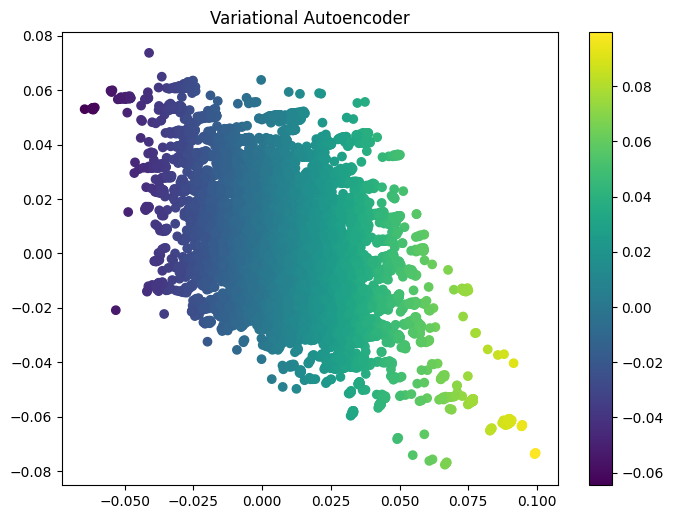

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_norm, df_norm,
                                                    test_size=0.33, random_state=42)

hist=vae.fit(X_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        validation_data=(X_test, None))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
print(X_test.shape)
print(X_test[0])
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
print(x_test_encoded.shape)
print(x_test_encoded)
print(y_test.shape)
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=x_test_encoded[:, 0])
plt.title('Variational Autoencoder')
plt.colorbar()
plt.show()

In [ ]:
def plt_hist(hist):
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

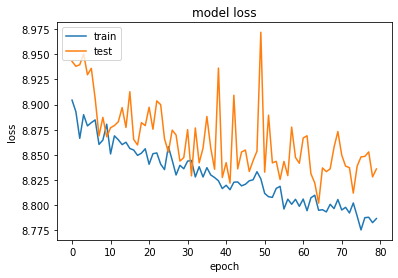

In [ ]:
plt_hist(hist)
tags=df['tag'].unique()
le = LabelEncoder()
le.fit(tags)
encoded_tags=le.transform(tags)

In [ ]:
x_test_encoded = encoder.predict(df_norm, batch_size=batch_size)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plt_reduce(x, color='tag'):
    '''
    Plot Scatter with color
    '''
    plt.figure(figsize=(6, 6))
    plt.scatter(x[:, 0], x[:, 1], c=le.transform(df[color]),
            alpha=.4, s=3**2, cmap='viridis')
    #plt.colorbar()
    plt.show()

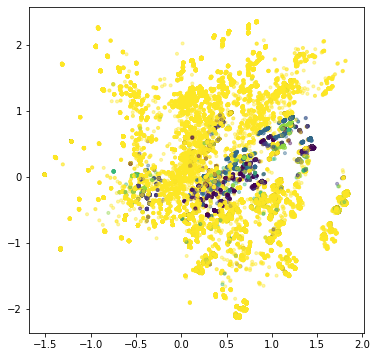

In [ ]:
pca      = PCA(n_components=2)
x_reduce = pca.fit_transform(x_test_encoded)
# Plot with merchant_category_id color
plt_reduce(x_reduce, 'tag')

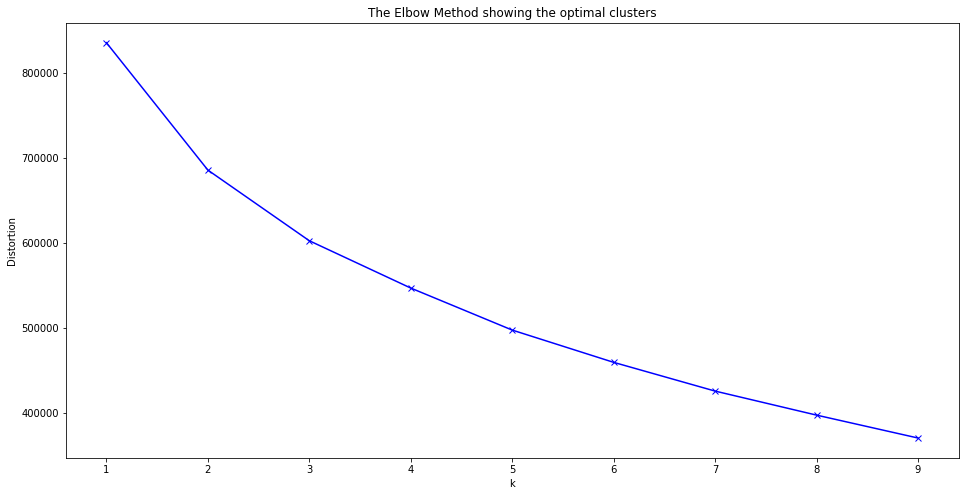

In [ ]:
from sklearn.cluster import KMeans
X=x_test_encoded #df_norm, decoded_df
# Collecting the distortions into list
distortions = []
K = range(1,10)
for k in K:
 kmeanModel = KMeans(n_clusters=k)
 kmeanModel.fit(X)
 distortions.append(kmeanModel.inertia_)
# Plotting the distortions
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal clusters')
plt.show()

In [ ]:
# Define the model
kmeans_model = KMeans(n_clusters=5, random_state=32932)
# Fit into our dataset fit
kmeans_predict = kmeans_model.fit_predict(X)
df['Cluster'] = kmeans_predict
display(df.head(20))

,word,sent_id,word_id_in_sent,head_id,part_of_speech_ADP,part_of_speech_ADV,part_of_speech_AUX,part_of_speech_CCONJ,part_of_speech_DET,part_of_speech_INTJ,...,Person_2,Person_3,Polarity_0,Polarity_Neg,Foreign_0,Foreign_Yes,Hyph_0,Hyph_Yes,tag,Cluster
0,Вице-премьер,0,1,7,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,O,3
1,по,0,2,4,1,0,0,0,0,0,...,0,0,1,0,1,0,1,0,O,0
2,социальным,0,3,4,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,O,2
3,вопросам,0,4,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,O,2
4,Татьяна,0,5,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,B-PER,1
5,Голикова,0,6,5,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,I-PER,3
6,рассказала,0,7,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,O,1
7,",",0,8,13,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,O,0
8,в,0,9,11,1,0,0,0,0,0,...,0,0,1,0,1,0,1,0,O,0
9,каких,0,10,11,0,0,0,0,1,0,...,0,0,1,0,1,0,1,0,O,2


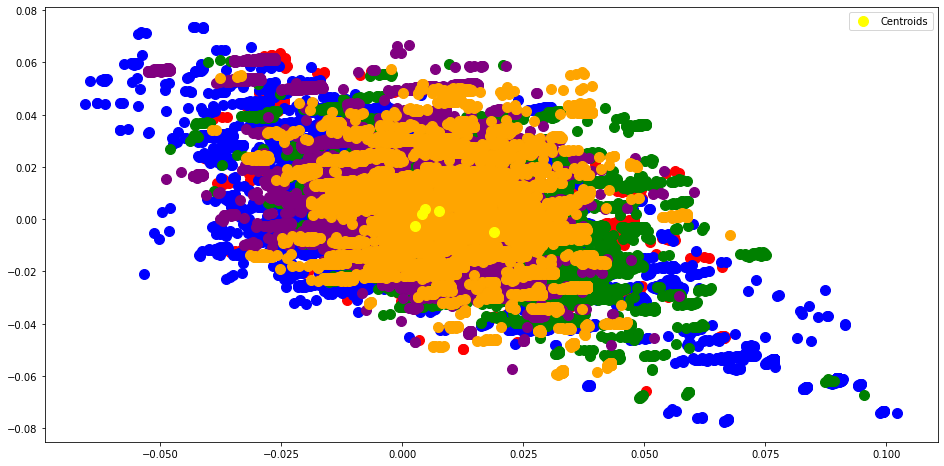

In [ ]:
# Visualising the clusters
plt.figure(figsize=(16,8))
plt.scatter(X[kmeans_predict == 0, 0], X[kmeans_predict == 0, 1], s = 100, c = 'red')
plt.scatter(X[kmeans_predict == 1, 0], X[kmeans_predict == 1, 1], s = 100, c = 'blue')
plt.scatter(X[kmeans_predict == 2, 0], X[kmeans_predict == 2, 1], s = 100, c = 'green')
plt.scatter(X[kmeans_predict == 3, 0], X[kmeans_predict == 3, 1], s = 100, c = 'purple')
plt.scatter(X[kmeans_predict == 4, 0], X[kmeans_predict == 4, 1], s = 100, c = 'orange')
# Plotting the centroids of the clusters
plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroids')
plt.legend()

In [ ]:
from pandas.compat import numpy
# Create the model
from keras.models import Sequential, Input
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, roc_curve,roc_auc_score
X=x_test_encoded#encoded_df,df_norm
Y=le.transform(df['tag'])
Y = to_categorical(Y, len(tags))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=10, test_size=0.2)
original_dim= X.shape[1]
print(original_dim)
input_shape = (original_dim, )
model = Sequential()
model.add(Dense(56, input_shape=input_shape, activation='relu'))
model.add(Dense(28, activation='relu'))
model.add(Dense(len(tags), activation='softmax'))
# Configure the model and start training
print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=14, batch_size=250, verbose=2, validation_split=0.2)


56
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 56)                3192      
                                                                 
 dense_71 (Dense)            (None, 28)                1596      
                                                                 
 dense_72 (Dense)            (None, 7)                 203       
                                                                 
Total params: 4,991
Trainable params: 4,991
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/14
470/470 - 6s - loss: 0.4292 - accuracy: 0.9011 - val_loss: 0.2476 - val_accuracy: 0.9290 - 6s/epoch - 12ms/step
Epoch 2/14
470/470 - 3s - loss: 0.2179 - accuracy: 0.9411 - val_loss: 0.2090 - val_accuracy: 0.9441 - 3s/epoch - 6ms/step
Epoch 3/14
470/470 - 3s - loss: 0.1971 - accuracy: 0.9477 - va

In [ ]:
print("Evaluate on test data")

results = model.evaluate(X_test, Y_test, batch_size=128)
print("test loss, test acc:", results)

print('prediction:')
Y_pred = model.predict(X_test)



print('program end...')
print()


print("Classifiction Report :")
y_pred = [np.argmax(y, axis=None, out=None) for y in Y_pred]
y_test = [np.argmax(y, axis=None, out=None) for y in Y_test]
#le.inverse_transform(y_classes)
print(classification_report(y_test, y_pred))
print("Confusion matrix :")
print(confusion_matrix(y_test, y_pred))

Evaluate on test data
287/287 [==============================] - 1s 2ms/step - loss: 0.1845 - accuracy: 0.9496
test loss, test acc: [0.18453659117221832, 0.9495715498924255]
prediction:
program end...

Classifiction Report :
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       914
           1       0.57      0.44      0.50       865
           2       0.94      0.97      0.95       787
           3       0.00      0.00      0.00       126
           4       0.60      0.27      0.37       718
           5       0.98      0.79      0.88       527
           6       0.97      0.99      0.98     32709

    accuracy                           0.95     36646
   macro avg       0.68      0.59      0.62     36646
weighted avg       0.94      0.95      0.94     36646

Confusion matrix :
[[  627   105     1     0    16     0   165]
 [  171   383     2     0    14     0   295]
 [    4     6   764     0     1     2    10]
 [   30     6     0     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.neural_network import MLPClassifier
X=x_test_encoded#encoded_df,df_norm

Y=df['tag']
print(X.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=10, test_size=0.2)
clf = MLPClassifier(hidden_layer_sizes=(56,28,14,), max_iter=10,activation = 'relu',solver='adam',random_state=1)
clf.classes_=Y
clf.n_outputs_=7
clf.out_activation_='softmax'
print(X_train.shape)
print(Y_train.shape)
clf.fit(X_train, Y_train)

#pickle.dump(model, open(filename, 'wb')) #save trained model

(183228, 56)
(146582, 56)
(146582,)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(hidden_layer_sizes=(56, 28, 14), max_iter=10, random_state=1)

In [ ]:
print('prediction:')
y_pred = clf.predict(X_test)
print(type(y_pred))
print()

print('Score:')
score = clf.score(X_test,Y_test)
print(score)

print('program end...')
print()


print("Classifiction Report :")
print(classification_report(Y_test, y_pred))
print("Confusion matrix :")
print(confusion_matrix(Y_test, y_pred))

prediction:
<class 'numpy.ndarray'>

Score:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9500900507558806
program end...

Classifiction Report :
              precision    recall  f1-score   support

       B-LOC       0.68      0.71      0.70       914
       B-ORG       0.57      0.45      0.51       865
       B-PER       0.94      0.97      0.95       787
       I-LOC       0.00      0.00      0.00       126
       I-ORG       0.59      0.27      0.37       718
       I-PER       0.98      0.80      0.88       527
           O       0.97      0.99      0.98     32709

    accuracy                           0.95     36646
   macro avg       0.68      0.60      0.63     36646
weighted avg       0.94      0.95      0.94     36646

Confusion matrix :
[[  648   102     1     0    17     0   146]
 [  173   391     2     0    16     0   283]
 [    3     7   761     0     1     2    13]
 [   31     6     0     0    11     0    78]
 [   29    20     7     0   196     2   464]
 [    0    21    23     0     0   419    64]
 [   62   135    17     0    90     3 32402]]
